In [1]:
import pandas as pd
import os

# Loading Data

In [2]:
data_folder = 'Data'
filename = 'Clean_data.csv'
file_path = os.path.join(data_folder, filename)

if not os.path.isfile(file_path):
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")

# Read the CSV without parsing dates
merged_df = pd.read_csv(file_path)

In [3]:
Env_df = merged_df[['Inflation_Rate (%)','Avg_Interest_Rate','Output_gap (%)']]
Env_df

,Inflation_Rate (%),Avg_Interest_Rate,Output_gap (%)
0,0.20,9.880,2.45
1,0.97,8.880,2.68
2,1.03,8.630,2.95
3,1.98,8.080,3.62
4,1.78,10.755,3.41
...,...,...,...
75,1.26,4.500,-0.09
76,0.76,4.750,-0.02
77,0.01,5.000,-0.07
78,0.17,5.250,0.33


# Paper Based Environment

In [4]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium.spaces import Box

class PaperBasedEconomyEnv(gym.Env):
    def __init__(
        self,
        model_y,            # e.g. a LinearRegression() for Output Gap
        model_pi,           # e.g. a LinearRegression() for Inflation
        historical_df,      # historical data for reset()
        lookback_periods=2,
        inflation_target=2.0,
        output_gap_target=0.0,
        max_steps=50,
        

    ):
        super(PaperBasedEconomyEnv, self).__init__()

        # Store initial DataFrame and reset index
        self.model_y = model_y       # The trained model for predicting Output Gap
        self.model_pi = model_pi     # The trained model for predicting Inflation
        self.lookback_periods = lookback_periods
        self.inflation_target = inflation_target
        self.output_gap_target = output_gap_target
        self.historical_df = historical_df
        self.df = historical_df.iloc[0:3].copy()
        self.max_steps = max_steps  # number of timesteps per episode

        # Column references for readability
        self.cols = {
            'inflation': 'Inflation_Rate (%)',
            'output_gap': 'Output_gap (%)',
            'interest_rate': 'Avg_Interest_Rate'
        }

        # Action space: choose the next interest rate
        self.action_space = Box(low=-20.0, high= 20.0, shape=(1,), dtype=np.float32)

        # Observation space: for each of the last N periods, we store
        # [inflation, output_gap, interest_rate], plus 1 extra for interest_rate(t-1)
        obs_space_size = 3 * self.lookback_periods# + 1
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_space_size,), dtype=np.float32
        )

        self.current_idx = self.lookback_periods
        self.done = False

    def reset(self, seed=None, options=None):
        """
        Reset the environment:
          1. Choose a random start index that allows for the lookback period.
          2. Initialize self.df with 3 consecutive rows starting from the random index.
          3. Reset step counters and done flag.
          4. Return the initial observation.
        """
        super().reset(seed=seed)

        # Calculate the maximum possible starting index
        required_rows = self.lookback_periods + 1  # 2 lookbacks + 1 current step = 3 rows
        max_start = len(self.historical_df) - required_rows

        if max_start <= 0:
            raise ValueError(
                "DataFrame is too small for the given lookback_periods. "
                "Reduce lookback_periods or provide more data."
            )

        # Randomly select a starting index
        random_start_index = self.np_random.integers(low=0, high=max_start + 1)

        # Initialize self.df with 3 consecutive rows from the original DataFrame
        self.df = self.historical_df.iloc[random_start_index:random_start_index + required_rows].reset_index(drop=True).copy()

        # Set current_idx to point to the last row in the initial df
        self.current_idx = self.lookback_periods  # Zero-based indexing

        # Reset step counters and done flag
        self.episode_step = 0
        self.done = False

        # Get the initial observation
        obs = self._get_state()
        info = {}
        return obs, info


    def step(self, action):
        """
        1. Parse the current state
        2. Construct the feature vectors for each model
        3. Predict next_output_gap and next_inflation
        4. Compute reward
        5. Append new row to DataFrame
        6. Advance time index
        7. Return (state, reward, done, info)
        """
        if self.done:
            raise RuntimeError("Environment is done. Call reset().")
        
        self.episode_step += 1

        # Action is the chosen interest rate for this step
        interest_rate = float(action[0])
        # Current state (shape: (3*lookback_periods + 1,))
        state = self._get_state()

        # ---------------------------------------------------------
        # 1) Parse the state for clarity
        #    Example for lookback=2:
        #    state = [
        #        inflation(t-2), interest_rate(t-2), output_gap(t-2)
        #        inflation(t-1), interest_rate(t-1), output_gap(t-1)
        #    ]
        # ---------------------------------------------------------
        # Let's label them (assuming lookback_periods=2)
        inflation_t2        = state[0]      # inflation(t-2)
        interest_rate_t2    = state[1]  # interest_rate(t-2)
        output_gap_t2       = state[2]     # output_gap(t-2)
        inflation_t1        = state[3]      # inflation(t-1)
        interest_rate_t1    = state[4]  # interest_rate(t-1)
        output_gap_t1       = state[5]     # output_gap(t-1)
        # state[6] is interest_rate(t-1) repeated in your original code
        # (You might want to adjust that logic—see explanation below.)

        # ---------------------------------------------------------
        # 2) Construct model_y features
        #    Based on how model_y was trained:
        #        X_y columns = ['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']
        #
        #    This implies:
        #       Lag_y1 = output_gap(t-1)
        #       Lag_pi1 = inflation(t-1)
        #       Lag_i1 = interest_rate(t-1)
        #       Lag_i2 = interest_rate(t-2)
        # ---------------------------------------------------------
        features_y = pd.DataFrame({
            'Lag_y1': [output_gap_t1],
            'Lag_pi1': [inflation_t1],
            'Lag_i1': [interest_rate_t1],
            'Lag_i2': [interest_rate_t2]
        })

        # Predict the next output gap
        next_output_gap = self.model_y.predict(features_y)[0]

        # ---------------------------------------------------------
        # 3) Construct model_pi features
        #    Based on how model_pi was trained:
        #        X_pi columns = [
        #           'Output_gap (%)',
        #           'Lag_y1', 'Lag_y2',
        #           'Lag_pi1', 'Lag_pi2',
        #           'Lag_i1'
        #        ]
        #
        #    This implies:
        #       'Output_gap (%)' = *current* output gap used for next inflation
        #       Lag_y1 = output_gap(t-1)
        #       Lag_y2 = output_gap(t-2)
        #       Lag_pi1 = inflation(t-1)
        #       Lag_pi2 = inflation(t-2)
        #       Lag_i1 = interest_rate(t-1)
        #
        #    Here, we have a choice to use the brand-new next_output_gap or
        #    the last known output_gap(t-1). In some setups, we feed the
        #    newly predicted output_gap back in. That is an economic modeling
        #    choice—just be consistent with your original training approach.
        # ---------------------------------------------------------
        features_pi = pd.DataFrame({
            'Output_gap (%)': [next_output_gap],  # or output_gap_t1 if you prefer
            'Lag_y1': [output_gap_t1],
            'Lag_y2': [output_gap_t2],
            'Lag_pi1': [inflation_t1],
            'Lag_pi2': [inflation_t2],
            'Lag_i1': [interest_rate_t1],
            'Lag_i2': [interest_rate_t2]
        })

        # Predict the next inflation
        next_inflation = self.model_pi.predict(features_pi)[0]

        # ---------------------------------------------------------
        # 4) Compute reward
        #    Negative MSE-like penalty from inflation & output gap deviation
        # ---------------------------------------------------------
        reward = -(
            0.5 * (next_inflation - self.inflation_target) ** 2
            + 0.5 * (next_output_gap - self.output_gap_target) ** 2
        )

        # ---------------------------------------------------------
        # 5) Append new row to the DataFrame
        # ---------------------------------------------------------
        new_row = {
            self.cols['inflation']: next_inflation,
            self.cols['output_gap']: next_output_gap,
            self.cols['interest_rate']: interest_rate
        }
        # NOTE: .append() is deprecated in recent Pandas; here’s one alternative:

        self.df = pd.concat([self.df, pd.DataFrame([new_row])], ignore_index=True)

        # ---------------------------------------------------------
        # 6) Advance time index and check termination
        # ---------------------------------------------------------
        self.current_idx += 1

        if self.episode_step >= self.max_steps:
            self.done = True

        # 7) Return the new state, reward, done, truncated, info
        
        truncated = False

        return self._get_state(), reward, self.done, truncated, {}

    def _get_state(self):
        """
        Builds an array of shape (3*lookback_periods + 1,).
        For lookback=2, we collect:
          [inflation(t-2), rate(t-2), gap(t-2), inflation(t-1), rate(t-1), gap(t-1)]
        """
        # Retrieve the current row and the previous row
        row_t_minus_1 = self.df.iloc[self.current_idx]
        row_t_minus_2 = self.df.iloc[self.current_idx - 1]

        # Convert both rows to lists
        current_row_list = row_t_minus_1.tolist()
        previous_row_list = row_t_minus_2.tolist()

        # Combine the two lists
        state = previous_row_list + current_row_list

        return np.array(state, dtype=np.float32)

# Importing ANN Models

In [5]:
from ANN import ANN_Model

ann_model_y = ANN_Model.load('ANN_Weights/y.pth',input_dim= 4, hidden_dim=3)
ann_model_pi = ANN_Model.load('ANN_Weights/pi.pth',input_dim= 7, hidden_dim=4)

Model loaded from ANN_Weights/y.pth
Model loaded from ANN_Weights/pi.pth


c:\Users\sebas\Desktop\LSE_2.0\MSc Statistics\ST449\ST449_Project\ANN.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


# Training OLS

In [7]:
# Define Variables
merged_df['Lag_y1'] = merged_df['Output_gap (%)'].shift(1)
merged_df['Lag_y2'] = merged_df['Output_gap (%)'].shift(2)
merged_df['Lag_pi1'] = merged_df['GDP Deflator'].shift(1)
merged_df['Lag_pi2'] = merged_df['GDP Deflator'].shift(2)
merged_df['Lag_i1'] = merged_df['Avg_Interest_Rate'].shift(1)
merged_df['Lag_i2'] = merged_df['Avg_Interest_Rate'].shift(2)

# Drop rows with NaN values created due to lagging
merged_df = merged_df.dropna()

print(merged_df)

   Quarter  Avg_Interest_Rate  GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%)  \
2   1988Q1              8.630         133283        137215            2.95   
3   1988Q2              8.080         136630        141576            3.62   
4   1988Q3             10.755         140801        145602            3.41   
5   1988Q4             12.880         144969        149469            3.10   
6   1989Q1             12.880         148623        152205            2.41   
..     ...                ...            ...           ...             ...   
75  2006Q2              4.500         367042        366712           -0.09   
76  2006Q3              4.750         370883        370824           -0.02   
77  2006Q4              5.000         372900        372629           -0.07   
78  2007Q1              5.250         376958        378202            0.33   
79  2007Q2              5.500         386144        387920            0.46   

    GDP Deflator  Inflation_Rate (%)  Lag_y1  Lag_y2  Lag_pi1  

In [8]:
# Define Variables
merged_df['Lag_y1'] = merged_df['Output_gap (%)'].shift(1)
merged_df['Lag_y2'] = merged_df['Output_gap (%)'].shift(2)
merged_df['Lag_pi1'] = merged_df['GDP Deflator'].shift(1)
merged_df['Lag_pi2'] = merged_df['GDP Deflator'].shift(2)
merged_df['Lag_i1'] = merged_df['Avg_Interest_Rate'].shift(1)
merged_df['Lag_i2'] = merged_df['Avg_Interest_Rate'].shift(2)

# Drop rows with NaN values created due to lagging
merged_df = merged_df.dropna()

print(merged_df)

from sklearn.linear_model import LinearRegression

# Linear Model (SVAR) Implementation

X_y = merged_df[['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']]
y_y = merged_df['Output_gap (%)']

X_pi = merged_df[['Output_gap (%)', 'Lag_y1', 'Lag_y2', 'Lag_pi1', 'Lag_pi2', 'Lag_i1','Lag_i2']]
y_pi = merged_df['Inflation_Rate (%)']

ols_model_y = LinearRegression()
ols_model_pi = LinearRegression()

    # Fit Models
ols_model_y.fit(X_y, y_y)
ols_model_pi.fit(X_pi, y_pi)

   Quarter  Avg_Interest_Rate  GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%)  \
4   1988Q3          10.755000         140801        145602            3.41   
5   1988Q4          12.880000         144969        149469            3.10   
6   1989Q1          12.880000         148623        152205            2.41   
7   1989Q2          13.750000         151262        153833            1.70   
8   1989Q3          13.823333         155370        156753            0.89   
..     ...                ...            ...           ...             ...   
75  2006Q2           4.500000         367042        366712           -0.09   
76  2006Q3           4.750000         370883        370824           -0.02   
77  2006Q4           5.000000         372900        372629           -0.07   
78  2007Q1           5.250000         376958        378202            0.33   
79  2007Q2           5.500000         386144        387920            0.46   

    GDP Deflator  Inflation_Rate (%)  Lag_y1  Lag_y2  Lag_pi1  

LinearRegression()

# Manual Test of Environment

In [9]:
env = PaperBasedEconomyEnv(
    historical_df=Env_df,
    model_y= ols_model_y,
    model_pi= ols_model_pi,
    lookback_periods=2,
    inflation_target=1000,
    output_gap_target=0.0,
    max_steps=50  # Force each episode to be 50 steps
)

In [10]:
"""env = PaperBasedEconomyEnv(
    historical_df=Env_df,
    model_y= ann_model_y,
    model_pi= ann_model_pi,
    lookback_periods=2,
    inflation_target=1000,
    output_gap_target=0.0,
    max_steps=50  # Force each episode to be 50 steps
)"""

'env = PaperBasedEconomyEnv(\n    historical_df=Env_df,\n    model_y= ann_model_y,\n    model_pi= ann_model_pi,\n    lookback_periods=2,\n    inflation_target=1000,\n    output_gap_target=0.0,\n    max_steps=50  # Force each episode to be 50 steps\n)'

In [11]:
env.reset()
print(env.df)

   Inflation_Rate (%)  Avg_Interest_Rate  Output_gap (%)
0               -0.11               8.88           -1.89
1                0.56               7.38           -1.72
2                1.97               5.88           -1.70


In [12]:
action = [1000000]
state, reward, done, truncated, info = env.step(action)
print("State: ", state)
print(f"Action: {action}, Reward: {reward}, Done: {done}")
print(env.df)

State:  [ 1.9700000e+00  5.8800001e+00 -1.7000000e+00  2.9962912e-01
  1.0000000e+06 -9.0276003e-01]
Action: [1000000], Reward: -499700.82325322746, Done: False
   Inflation_Rate (%)  Avg_Interest_Rate  Output_gap (%)
0           -0.110000               8.88        -1.89000
1            0.560000               7.38        -1.72000
2            1.970000               5.88        -1.70000
3            0.299629         1000000.00        -0.90276


In [13]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

env = PaperBasedEconomyEnv(
        historical_df=Env_df,
        model_y=ann_model_y,
        model_pi=ann_model_pi,
        lookback_periods=2,
        inflation_target=1000,
        output_gap_target=0.0,
        max_steps=50  # Force each episode to be 50 steps
    )

log_dir = "./logs/"
env = Monitor(env, filename=log_dir)

In [14]:
import torch
venv = DummyVecEnv([lambda: env])  # wrap your environment

model = PPO(
    policy="MlpPolicy",
    env=venv,
    verbose=1,
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # You can tune many hyperparameters here
)
model.learn(total_timesteps=1000)

Using cuda device


c:\Users\sebas\Desktop\LSE_2.0\MSc Statistics\ST449\ST449_Project\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -2.5e+07 |
| time/              |          |
|    fps             | 229      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Reset the environment
obs = venv.reset()

# This list will hold (step, action, reward, observation)
step_log = []


for i in range(30):
    # Use the trained model to predict an action
    action, _ = model.predict(obs)
    # Take a step in the environment
    obs, rewards, dones, infos = venv.step(action)

    # For a single-environment VecEnv, obs has shape (1, obs_dim),
    # action has shape (1, action_dim), and rewards/dones are length-1 arrays.
    # We'll store the *first* environment's values.
    print(obs)
    print(f"Step: {i}, Action: {action}, Reward: {rewards}, Done: {dones}")

    # Convert to float to avoid arrays in the log
    step_idx = i
    act_value = float(action[0][0])  # if your action shape is (1, 1)
    reward_value = float(rewards[0])

    # obs[0] is the actual observation array for the first (and only) env
    # We'll store a copy so it doesn't get overwritten next iteration
    observation_array = obs[0].copy()

    step_log.append((step_idx, act_value, reward_value, observation_array))

    # If done, reset the environment
    if dones[0]:
        obs = venv.reset()




[[1.57       4.375      0.46       0.21754716 0.70338607 0.4733261 ]]
Step: 0, Action: [[0.70338607]], Reward: [-499782.6], Done: [False]
[[0.21754716 0.70338607 0.4733261  0.05763914 1.3252469  0.99091136]]
Step: 1, Action: [[1.3252469]], Reward: [-499942.84], Done: [False]
[[0.05763914 1.3252469  0.99091136 0.16182084 1.8408717  1.2120147 ]]
Step: 2, Action: [[1.8408717]], Reward: [-499838.94], Done: [False]
[[0.16182084 1.8408717  1.2120147  0.20941915 0.6928764  1.3740892 ]]
Step: 3, Action: [[0.6928764]], Reward: [-499791.53], Done: [False]
[[0.20941915 0.6928764  1.3740892  0.06005218 0.27337095 1.613473  ]]
Step: 4, Action: [[0.27337095]], Reward: [-499941.25], Done: [False]
[[ 0.06005218  0.27337095  1.613473    0.08073839 -1.1262324   1.7557054 ]]
Step: 5, Action: [[-1.1262324]], Reward: [-499920.8], Done: [False]
[[ 0.08073839 -1.1262324   1.7557054   0.00836756  0.44457412  1.9294605 ]]
Step: 6, Action: [[0.44457412]], Reward: [-499993.5], Done: [False]
[[0.00836756 0.444574

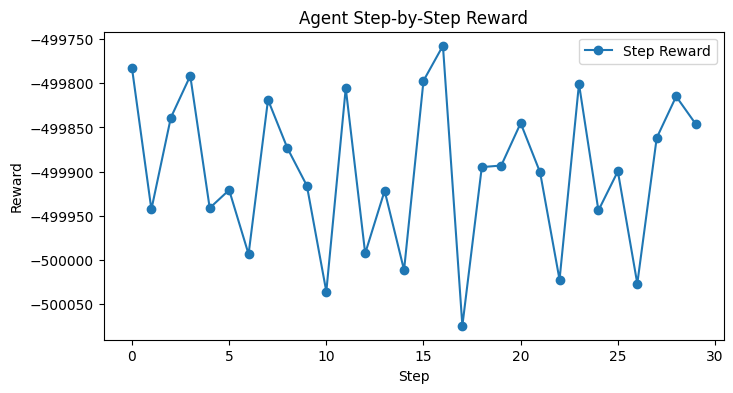

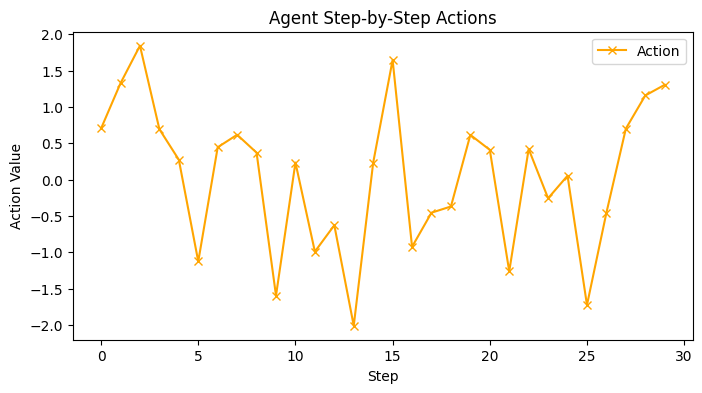

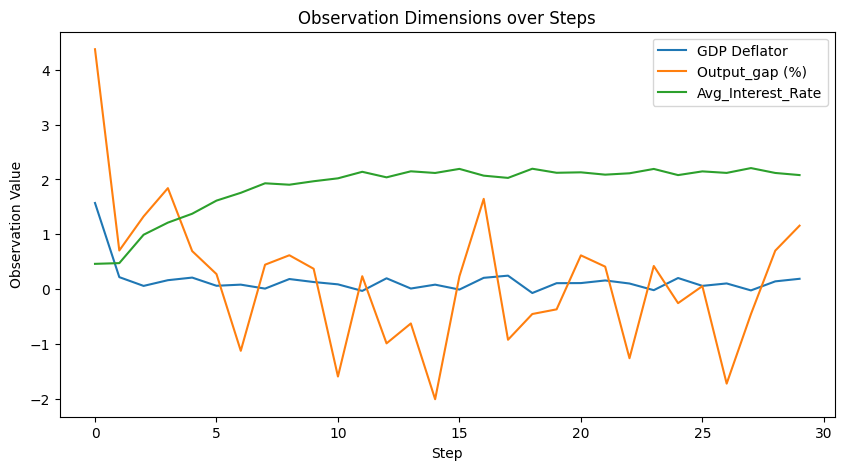

In [16]:
col_names = [
    'GDP Deflator',
    'Output_gap (%)',
    'Avg_Interest_Rate'
]

# -------------------------------------------------
# Convert the logged data into NumPy arrays for plotting
# -------------------------------------------------
steps = np.array([x[0] for x in step_log])
actions = np.array([x[1] for x in step_log])
step_rewards = np.array([x[2] for x in step_log])
observations = np.array([x[3] for x in step_log])  # shape: (num_steps, obs_dim)

# -------------------------------------------------
# 1) Plot the step-by-step rewards
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(steps, step_rewards, marker='o', label='Step Reward')
plt.title("Agent Step-by-Step Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.show()

# -------------------------------------------------
# 2) Plot the step-by-step actions
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(steps, actions, marker='x', color='orange', label='Action')
plt.title("Agent Step-by-Step Actions")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.legend()
plt.show()

# -------------------------------------------------
# 3) Plot the observations (each dimension separately)
# -------------------------------------------------
obs_dim = observations.shape[1]  # how many features per observation
plt.figure(figsize=(10, 5))
for dim in range(3):
    plt.plot(steps, observations[:, dim], label= col_names[dim])

plt.title("Observation Dimensions over Steps")
plt.xlabel("Step")
plt.ylabel("Observation Value")
plt.legend()
plt.show()